<a href="https://colab.research.google.com/github/ThanosApostolou/aics-pattern-recognition/blob/main/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# INSTALL DEPENDENCIES
# Uncomment and run only once.
!pip install matplotlib numpy pandas scikit-learn scipy tensorflow pyclustering

In [2]:
# IMPORTS AND GLOBAL CONSTANTS

# Load the TensorBoard notebook extension
%load_ext tensorboard

import tensorflow as tf
import datetime, os
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import typing
import numpy.typing as np_typing

##MAIN PROGRAM VARIABLES##
##(0): dataset: np array of strings
##(1): dataframe: original dataset in its primal form
##(2): ratings_num_df: new dataframe storing the number of rated items per unique user
##(3): ratings_span_df: new dataframe storing the timespan in days for each user
##(4): minimum_ratings - maximum_ratings => ratings_df=> (i) final_df

# Constants
DATASET_FILE_PATH = "./Dataset.npy"
#Define the figures path
FIGURES_PATH = "figures"
os.makedirs(FIGURES_PATH, exist_ok=True)
# #Define the data folder path
DATAFOLDER_PATH = "datafiles"
os.makedirs(DATAFOLDER_PATH, exist_ok=True)

if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab import drive
  drive.mount('/content/drive/')
  DATASET_FILE_PATH = "/content/drive/My Drive/Colab Notebooks/Dataset.npy"


2023-03-17 18:04:21.563602: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-17 18:04:23.193826: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-17 18:04:23.194992: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 18:04:26.494772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
dataset: np.ndarray = np.load(DATASET_FILE_PATH)
# TODO delete this when we fix performance
dataset = dataset[:min(1000000, dataset.size)]

In [4]:
def create_dataframe_cached(dataset: np.ndarray) -> pd.DataFrame:
    #Define the splitter lambda function in order to tokenize the initial string data.
    splitter: typing.Callable[[str], list[str]] = lambda s: s.split(",")
    #Apply the splitter lambda function on the string np array
    dataset = np.array([splitter(x) for x in dataset])
    #Set the pickle file for storing the initial dataframe
    pickle_file = os.path.join(DATAFOLDER_PATH, "dataframe.pkl")
    #Check the existence of the specified file.
    if os.path.exists(pickle_file):
        #Load the pickle file
        dataframe: pd.DataFrame = pd.read_pickle(pickle_file)
        return dataframe
    else:
        #Create the dataframe object.
        dataframe = pd.DataFrame(dataset, columns=['User','Movie','Rating','Date'])
        #Convert the string elements of the "Users" series into integers
        dataframe["User"] = dataframe["User"].apply(lambda s:np.int64(s.replace("ur","")))
        #Convert the string elements of the "Movies" series into integers
        dataframe["Movie"] = dataframe["Movie"].apply(lambda s:np.int64(s.replace("tt","")))
        #Convert the string elements of the "Ratings" series into integers
        dataframe["Rating"] = dataframe["Rating"].apply(lambda s:np.int64(s))
        #Convert the string element of "Dates" series into datetime Object
        dataframe["Date"] = pd.to_datetime(dataframe["Date"])
        dataframe.to_pickle(pickle_file)
        return dataframe


dataframe: pd.DataFrame = create_dataframe_cached(dataset)

In [5]:
#Get the unique users in the dataset.
users = dataframe["User"].unique()
#Get the number of unique users
users_num = len(users)
#Get the unique movie items in the dataset.
movies = dataframe["Movie"].unique()
#Get the number of unique movies
movies_num = len(movies)
#Get the total number of existing ratings.
ratings_num = dataframe.shape[0]
#Report the number of unique Users and Movies in the dataset
print("INITIAL DATASET: {0} number of unique users and {1} of unique movies".format(users_num, movies_num))
#Report the total number of existing ratings in the dataset
print("INITIAL DATASET: {} total number of existing ratings".format(ratings_num))

INITIAL DATASET: 355343 number of unique users and 118274 of unique movies
INITIAL DATASET: 1000000 total number of existing ratings


In [6]:
def create_ratings_num_df_cached(dataframe: pd.DataFrame) -> pd.DataFrame:
    #Define the pickle file that will store the time span per user dataframe
    pickle_file = os.path.join(DATAFOLDER_PATH, "ratings_num_df.pkl")
    #Check the existence of the previously defined pickle file
    if os.path.exists(pickle_file):
        #Load the pickle file
        ratings_num_df: pd.DataFrame = pd.read_pickle(pickle_file)
        return ratings_num_df
    else:
        ratings_num_df = dataframe.groupby("User")["Rating"].count().sort_values(ascending=False).reset_index(name="ratings_num")
        #Save the previously created dataframe to pickle
        ratings_num_df.to_pickle(pickle_file)
        return ratings_num_df


ratings_num_df: pd.DataFrame = create_ratings_num_df_cached(dataframe)
ratings_num_df

,User,ratings_num
0,2467618,6808
1,4445210,5267
2,2483625,4396
3,4888011,3358
4,2488512,3275
...,...,...
355338,6240081,1
355339,6240091,1
355340,6240141,1
355341,6240179,1


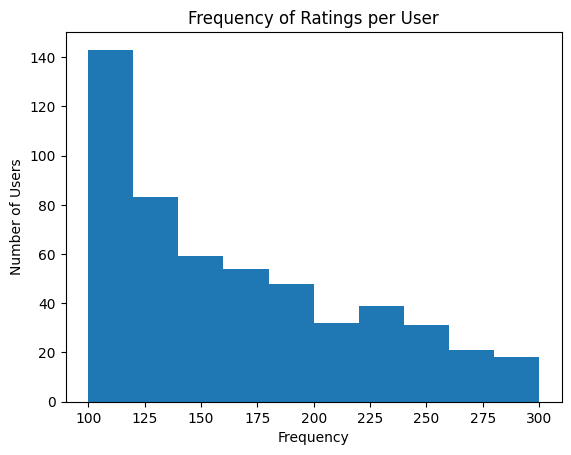

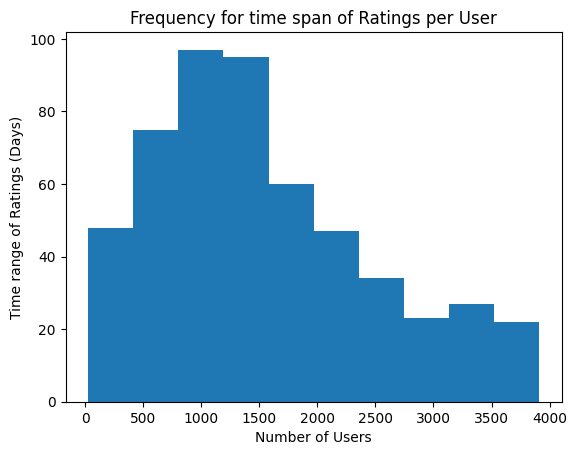

In [7]:
def create_ratings_span_df_cached(dataframe: pd.DataFrame) -> pd.DataFrame:
    #Set the pickle file that will store the time span per user dataframe
    pickle_file = os.path.join(DATAFOLDER_PATH, "ratings_span_df.pkl")
    if os.path.exists(pickle_file):
        ratings_span_df: pd.DataFrame = pd.read_pickle(pickle_file)
        return ratings_span_df
    else:
        ratings_span_df = dataframe.groupby("User")["Date"].apply(lambda date: max(date)-min(date)).sort_values(ascending=False).reset_index(name="ratings_span")
        ratings_span_df.to_pickle(pickle_file)
        return ratings_span_df


def plot_histograms(reduced_ratings_df: pd.DataFrame, minimum_ratings: int, maximum_ratings: int):
    #Generate the frequency histogram for the number of ratings per user
    reduced_ratings_df["ratings_num"].plot(kind='hist', title='Frequency of Ratings per User', xticks=range(minimum_ratings, maximum_ratings+1, 25))
    plt.xlabel('Frequency')
    plt.ylabel('Number of Users')
    plt.show()

    #Generate the frequency histogram for the time span of ratings per user
    reduced_ratings_df["ratings_span"].plot(kind='hist', title='Frequency for time span of Ratings per User')
    plt.xlabel('Number of Users')
    plt.ylabel('Time range of Ratings (Days)')
    plt.show()   


ratings_span_df = create_ratings_span_df_cached(dataframe)

#Create a new ratings dataframe by joining the previously defined dataframe
ratings_df = ratings_num_df.join(ratings_span_df.set_index("User"),on="User")
ratings_df["ratings_span"]=ratings_df["ratings_span"].dt.days
#Set the threshold values for the minimum and maximum number of Ratings per user
minimum_ratings = 100
maximum_ratings = 300
#Discard all users that do not pertain to the previous range of ratings
reduced_ratings_df = ratings_df.loc[(ratings_df["ratings_num"] >= minimum_ratings) & (ratings_df["ratings_num"] <= maximum_ratings)]

plot_histograms(reduced_ratings_df, minimum_ratings, maximum_ratings)                                              

In [8]:
#Get the final dataframe by excluding all users whose ratings fall outside the prespecified range
final_df = dataframe.loc[dataframe["User"].isin(reduced_ratings_df["User"])].reset_index()
#Drop the links (indices) to the original table
final_df = final_df.drop("index", axis=1)
#Get the unique users and items in the final dataframe along with the final number of ratings
final_users = final_df["User"].unique()
final_movies = final_df["Movie"].unique()
final_users_num = len(final_users)
final_movies_num = len(final_movies)
final_ratings_num = len(final_df)

#Report the final number of unique users and movies in the dataset
print("REDUCED DATASET: {0} number of unique users and {1} number of unique movies".format(final_users_num, final_movies_num))
#Report the final number of existing ratings in the dataset
print("REDUCED DATASET: {} number of existing ratings in the dataset".format(final_ratings_num))

REDUCED DATASET: 528 number of unique users and 29635 number of unique movies
REDUCED DATASET: 87686 number of existing ratings in the dataset


In [9]:
final_users

array([ 4111911,  2074560,   157498,  1683802,   992453,   940861,
          18365,  2449095,  2326544,   165374,  4491531,   383429,
         355734,  2581298,  2547554,   593719,  1832331,  2382545,
         313019,  3379318,  2420383,  1693235,  3615725,  1307882,
        3613145,   581842,  2378994,    11762,  1741394,  1590118,
        3329978,  2072443,   935583,   296601,  2630196,   270791,
        2362867,   902607,  4593705,  2521222,   543054,  1052098,
        1516273,  2148320,  1803589,   218006,  1819548,  2293681,
        1457119,  3057109,   783721,  2812098,  2339662,  1046460,
        1722967,   450109,  2537516,   123856,   650655,  2747265,
        3032446,  2467778,  3001058,  3073914,  3783846,   835751,
        2642613,   708885,   394025,  1522352,  1069062,   786506,
        1332263,  2024359,  2380153,  1917678,  3673895,  3341647,
         591571,  1419266,   426613,  1598260,  3531661,  1083764,
        3313572,  1976688,  2709206,   171876,   443537,  1046

In [10]:
final_movies

array([ 74486,  52846,  75261, ..., 100347, 100369, 100414])

In [11]:
#We need to reset the users and items IDs in order to be able to construct a network of users and Movies. 
#Users and Movies IDs should be consecutive in the [1..final_users_num] and [1...final_movies_num]
#Initially, we need to acquire the sorted versions of the user and movies
sorted_final_users = np.sort(final_users)
sorted_final_movies = np.sort(final_movies)
#Generate the dictionary of final users as a mapping of the following 
#sorted_final_users --> [0...final_users_num-1]
final_users_dict = dict(zip(sorted_final_users,list(range(0,final_users_num))))
#Generate the dictionary of final items as a mapping of the following
final_movies_dict = dict(zip(sorted_final_movies,list(range(0,final_movies_num))))
#Apply the previously defined dictionary-based maps on the users and movies columns of the final dataframe
final_df["User"] = final_df["User"].map(final_users_dict)
final_df["Movie"] = final_df["Movie"].map(final_movies_dict)
#Get a grouped version of the original dataframe based on the unique final users
users_group_df = final_df.groupby("User")
#Initialize the adjacency matrix which stores the connection status for pair of users in the recommendation network
W = np.zeros((final_users_num, final_users_num))
#Iinitialize the matrix storing the number of commonly rated items for a pair of users
CommonRatings = np.zeros((final_users_num, final_users_num))
#Initialize the matrix of common ratings
#Matrix W will be of size [final_users_num x final_users_num],
#Let U = {u1, u2,...,un} be the final set of users and I = {i1,i2,...,im}
#final set of movies. By considering the function Fi: U -> P(I) where
#P(I) is the powerset of I, Fi(u) returns the subset of items that has been rated by user u. 
#In this context, the edge weight between any given pair of users (u,v) will be computed as:
#
#          |Intersection(Fi(u)),Fi(v))|
#W(u,v) =  -----------------------------
#               |Union(Fi(u),Fi(v))|
#
#
#In order to speed up the construction of the adjacency matrix for the ratings network, 
#construct a dictionary object that will store a set of rated items for each unique user.
user_items_dict = {}
# for user in final_users:
    #print(user)
    # user_index = final_users_dict[user]
    # user_movies = set(users_group_df.get_group(user_index)["Movie"])
    # user_items_dict[user_index] = user_movies
                                                 
# Initialize the dictionary for storing the set of rated items for each user
user_items_dict = {}
# print(final_users_dict)
# print(sorted_final_users)
# print(final_users_dict)
# For each unique user, find the set of movies that they rated
for user in final_users:
    if user in final_users_dict:
        user_index = final_users_dict[user]
        user_movies = set(users_group_df.get_group(user_index)["Movie"])
        user_items_dict[user_index] = user_movies 

In [12]:
user_ids = list(user_items_dict.keys())
user_ids.sort()
#Generate the sorted version of the dictionary
user_items_dict = {user_index:user_items_dict[user_index] for user_index in user_ids}
#Set the pickle file that will store the graph adjacency matrix W.
pickle_file_weights = os.path.join(DATAFOLDER_PATH, "w")
pickle_file_common_ratings = os.path.join(DATAFOLDER_PATH, "common_ratings")
#Check the existence of the previously defined pickle file
if os.path.exists(pickle_file_weights) & os.path.exists(pickle_file_common_ratings):
    #Load the pickle file
    W: np_typing.NDArray[np.float64] = np.load(pickle_file_weights)
    CommonRatings: np_typing.NDArray[np.float64] = np.load(pickle_file_common_ratings)
else:
    for source_user in user_items_dict.keys():
        for target_user in user_items_dict.keys():
            intersection_items = user_items_dict[source_user].intersection(user_items_dict[target_user])
            union_items = user_items_dict[source_user].union(user_items_dict[target_user])
            W[source_user, target_user] = len(intersection_items)/len(union_items)
            CommonRatings[source_user, target_user] = len(intersection_items)
    np.save(pickle_file_weights,W)
    np.save(pickle_file_common_ratings,CommonRatings)

In [13]:
W

array([[1.        , 0.00982801, 0.00645161, ..., 0.        , 0.        ,
        0.04229607],
       [0.00982801, 1.        , 0.0126183 , ..., 0.        , 0.        ,
        0.00854701],
       [0.00645161, 0.0126183 , 1.        , ..., 0.        , 0.        ,
        0.00393701],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.0513834 ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.04229607, 0.00854701, 0.00393701, ..., 0.0513834 , 0.        ,
        1.        ]])

In [14]:
CommonRatings

array([[201.,   4.,   2., ...,   0.,   0.,  14.],
       [  4., 210.,   4., ...,   0.,   0.,   3.],
       [  2.,   4., 111., ...,   0.,   0.,   1.],
       ...,
       [  0.,   0.,   0., ..., 122.,   0.,  13.],
       [  0.,   0.,   0., ...,   0., 109.,   0.],
       [ 14.,   3.,   1., ...,  13.,   0., 144.]])

In [15]:
final_df

,User,Movie,Rating,Date
0,313,9972,10,2005-01-16
1,203,6243,2,2005-01-16
2,203,10103,2,2005-01-16
3,25,14694,7,2005-01-16
4,25,18942,3,2005-01-16
...,...,...,...,...
87681,115,14341,9,2001-06-29
87682,89,14342,4,2001-05-06
87683,116,14342,8,2001-09-05
87684,51,14343,9,1999-08-28


#Δημιουργούμε έναν πίνακα χρηστών - ταινιών 
(οι χρήστες βρίσκονται στις γραμμές και οι ταινίες στις στήλες του πίνακα)
όπου τα στοιχεία του πίνακα είναι από 1 - 10. Εάν ο χρήστης δεν έχει αξιολογήσει την ταινία,
η αξιολόγηση που θα ανατεθεί είναι 0.

In [16]:
# Create a pivot table of user-movie ratings
ratings_matrix = final_df.pivot_table(index='User', columns='Movie', values='Rating')
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix

Movie,0,1,2,3,4,5,6,7,8,9,...,29625,29626,29627,29628,29629,29630,29631,29632,29633,29634
User,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric

Θέλουμε να δημιουργήσουμε τον πίνακα βαρών "λ" των χρηστών. Τον πίνακα αξιολογήσεων δηλαδή όπου η τιμή της αξιολόγησης είναι 1 εάν η ταινία έχει αξιολογηθεί από τον χρήστη ή 0 εάν δεν έχει αξιολογηθεί

In [18]:
# Threshold
threshold = 1

# Transform to binary
binary_matrix = np.where(ratings_matrix >= threshold, 1, 0)
binary_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
# Convert the matrix to a numpy array
matrix_array = ratings_matrix.to_numpy()

# Create a dictionary that maps each row of the matrix to its index
# matrix_dict = {tuple(row): i for i, row in enumerate(matrix_array)}

# ***Αλγόριθμοι Ομαδοποίησης Δεδομένων***

**Χρήση της Weighted Euclidean Distance**

In [20]:
# Kmeans
#final_df
import sklearn
import sklearn.cluster
import sklearn.metrics

myclustering = sklearn.cluster.KMeans(n_clusters=3)
print(myclustering)

myclustering.fit(ratings_matrix)

print(myclustering)

KMeans(n_clusters=3)


/run/media/thanos/BAAE0E3FAE0DF523/SHARED/THANOS_PROJECTS/aics-pattern-recognition/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)


In [21]:
from scipy.spatial.distance import pdist, cdist
import numpy as np

from scipy.sparse import csr_matrix

def pairwise_weighted_euclidean_distance(X, weights):
    # Find the indices of the rated movies for each pair of users
    rated_movies = (weights_sparse.T @ weights_sparse) > 0

    # Select only the rated movies for each pair of users
    X_rated = X_sparse[:, rated_movies]
    
    # Calculate the pairwise weighted Euclidean distance between 
    #users who have rated the same movie
    return cdist(X, metric='euclidean')

def kmeans_pairwise_weighted_euclidean(X, weights, k, max_iters=2):

    n, m = X.shape
    centroids = X[np.random.choice(n, k, replace=False)]
    distances = pairwise_weighted_euclidean_distance(X, weights)
    for i in range(max_iters):
        # Assign points to clusters
        cluster_assignments = np.argmin(distances, axis=1)

        # Recalculate cluster centroids
        for j in range(k):
            cluster_points = X[cluster_assignments == j]
            if len(cluster_points) > 0:
                centroids[j] = np.average(cluster_points, axis=0)

        # Update distances to centroids
        distances = pairwise_weighted_euclidean_distance(X, weights)

    return cluster_assignments, centroids


In [22]:
# Calculate the weighted Euclidean distance matrix

def create_euclidean_distance_matrix_cached(ratings_matrix: pd.DataFrame, binary_matrix: np_typing.NDArray) -> np_typing.NDArray[np.float64]:
    #Set the npy file that will store the Euclidean distance matrix
    npy_file = os.path.join(DATAFOLDER_PATH, "euclidean_distance_matrix.npy")
    if os.path.exists(npy_file):
        D: np_typing.NDArray[np.float64] = np.load(npy_file, allow_pickle=True)
        return D
    else:
        D = np.zeros((ratings_matrix.shape[0], ratings_matrix.shape[0]))

        for i in range(ratings_matrix.shape[0]):
            for j in range(i, ratings_matrix.shape[0]):
                d = np.sqrt(np.sum(binary_matrix[i,:]*binary_matrix[j,:] * (ratings_matrix.iloc[i,:] - ratings_matrix.iloc[j,:])**2))
                D[i,j] = d
                D[j,i] = d
        np.save(npy_file, D, allow_pickle=True, fix_imports=True)
        return D


D = create_euclidean_distance_matrix_cached(ratings_matrix, binary_matrix)
D[:5, :5]
print('D.shape', D.shape)

D.shape (528, 528)


# Clustering users using K-means
 We want to start by creating the symmetric D matrix which contains the pairwise weighted Euclidean distance for every pair of users.
 We calculate the distance between each user using 
*   dist_{u,v}=\sum_{k=1}^{n}\sqrt{|R_{u}(k) - R_{v}(k)|λ_{u}(k)λ_{v}(k)}




In [23]:
# Calculate the pairwise weighted Euclidean distance matrix
n = ratings_matrix.shape[0]
n = 100
Dist_euclidean = np.zeros((n, n))
for i in range(n):
  for j in range(i, n):
      d = np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * (ratings_matrix.loc[i,:] - ratings_matrix.loc[j,:])**2))
      Dist_euclidean[i,j] = d
      Dist_euclidean[j,i] = d

In [24]:
binary_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [25]:
ratings_matrix

Movie,0,1,2,3,4,5,6,7,8,9,...,29625,29626,29627,29628,29629,29630,29631,29632,29633,29634
User,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
df_euclidean = pd.DataFrame(Dist_euclidean)
df_euclidean

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,3.605551,3.605551,9.273618,4.123106,2.828427,3.162278,5.000000,4.000000,2.000000,...,9.273618,5.916080,0.000000,13.856406,0.0,8.485281,4.690416,8.062258,5.477226,0.000000
1,3.605551,0.000000,4.690416,6.403124,5.744563,3.000000,5.099020,2.236068,2.449490,0.000000,...,5.656854,4.000000,3.000000,5.385165,0.0,1.000000,0.000000,3.605551,0.000000,5.000000
2,3.605551,4.690416,0.000000,6.557439,6.708204,0.000000,1.000000,3.162278,0.000000,0.000000,...,4.472136,3.162278,0.000000,4.000000,0.0,2.449490,2.000000,5.000000,7.280110,1.000000
3,9.273618,6.403124,6.557439,0.000000,7.000000,3.000000,3.000000,8.485281,0.000000,0.000000,...,9.539392,17.916473,1.000000,17.058722,0.0,15.937377,5.291503,16.643317,11.269428,0.000000
4,4.123106,5.744563,6.708204,7.000000,0.000000,5.385165,7.000000,8.544004,10.535654,5.099020,...,0.000000,4.000000,3.605551,1.000000,4.0,5.744563,9.000000,8.000000,3.316625,16.941074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8.485281,1.000000,2.449490,15.937377,5.744563,3.000000,0.000000,7.000000,0.000000,0.000000,...,6.164414,11.045361,2.236068,12.409674,0.0,0.000000,2.236068,7.874008,9.433981,0.000000
96,4.690416,0.000000,2.000000,5.291503,9.000000,1.000000,0.000000,6.782330,3.000000,2.645751,...,6.000000,0.000000,6.000000,8.062258,0.0,2.236068,0.000000,6.480741,0.000000,7.745967
97,8.062258,3.605551,5.000000,16.643317,8.000000,7.615773,0.000000,7.810250,0.000000,0.000000,...,6.164414,3.000000,5.000000,7.000000,0.0,7.874008,6.480741,0.000000,4.123106,0.000000
98,5.477226,0.000000,7.280110,11.269428,3.316625,2.000000,0.000000,5.000000,3.000000,0.000000,...,5.916080,11.704700,0.000000,4.123106,2.0,9.433981,0.000000,4.123106,0.000000,8.000000


Στον πίνακα αποστάσεων που έχουμε δημιουργήσει, θα τρέξουμε τον αλγόριθμο k-means ώστε να αποτιμήσουμε την ομοιότητα των χρηστών χρησιμοποιώντας τις μεταξύ τους αποστάσεις.

In [27]:
from sklearn.cluster import KMeans
# Cluster the users using K-means
kmeans = KMeans(n_clusters=5, n_init=10).fit(D)

# Get the cluster labels
labels_euclidean = kmeans.labels_

# Print the labels
print(labels_euclidean)

[4 3 3 2 0 3 3 3 1 1 1 1 1 1 3 1 1 1 4 1 4 1 1 4 3 2 0 4 3 1 1 1 1 4 0 0 3
 1 3 1 0 3 0 1 1 3 3 3 1 1 1 2 1 1 1 4 3 0 3 1 1 4 0 4 0 3 1 1 0 3 2 0 3 4
 1 2 2 1 1 1 3 3 4 4 1 4 4 1 2 3 4 4 1 4 1 4 3 4 4 3 3 3 2 4 1 4 1 2 1 1 1
 1 2 1 0 3 3 0 3 0 3 3 1 4 1 2 3 2 4 0 0 3 2 2 1 1 3 3 3 1 4 3 2 3 1 4 4 4
 0 3 1 4 3 4 3 4 2 4 0 1 4 0 1 1 3 3 4 3 2 4 0 4 0 3 1 0 1 2 1 2 1 2 3 1 3
 1 3 2 1 2 1 2 4 0 1 4 4 4 3 0 3 1 1 3 1 4 3 2 4 0 3 0 3 3 3 0 4 1 1 0 0 4
 2 1 3 1 4 3 2 1 3 2 3 3 0 1 1 3 3 1 1 1 3 4 3 0 1 2 0 1 4 4 0 0 4 0 3 4 3
 3 3 1 1 4 1 3 1 1 3 2 4 4 3 0 3 3 3 0 1 2 3 1 0 0 4 4 1 3 3 1 4 1 4 4 3 1
 3 3 2 1 3 1 4 3 3 0 3 3 1 3 4 1 4 3 3 3 4 4 1 3 1 4 2 1 1 2 3 4 4 0 2 1 4
 0 1 3 4 1 3 4 4 2 1 3 4 3 1 4 3 4 3 2 0 4 1 3 1 4 3 3 2 3 1 3 3 3 0 4 0 3
 0 1 4 4 4 3 1 0 4 4 1 1 1 1 3 4 3 3 2 0 1 3 3 3 0 4 3 2 2 3 0 2 3 3 0 4 3
 2 0 4 1 2 2 4 0 3 4 0 3 3 0 2 3 1 0 0 4 0 1 2 1 3 4 3 3 0 1 0 4 1 3 2 2 0
 0 1 4 1 0 1 1 0 1 3 3 2 1 4 0 1 4 4 1 1 3 1 4 4 2 3 4 1 2 1 2 3 0 0 4 0 4
 3 3 3 3 0 1 4 4 4 4 0 3 

Cluster the users, by using a custom 
dist = 1 - np.abs(np.sum(R_u*R_v*weights_u*weights_l)/(np.sqrt(R^2_u*weights_u*weights_l)*np.sqrt(R^2_v*weights_u*weights_l)

---



In [28]:
# Calculate the pairwise weighted Cosine distance matrix
n = ratings_matrix.shape[0]
n = 100
Dist_cosine = np.zeros((n, n))
for i in range(n):
  for j in range(i, n):
      d = 1 - np.abs(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:] * ratings_matrix.loc[j,:]) / (np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:])* np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[j,:])))))
      Dist_cosine[i,j] = d
      Dist_cosine[j,i] = d

/tmp/ipykernel_7421/851568041.py:7: RuntimeWarning: invalid value encountered in double_scalars
  d = 1 - np.abs(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:] * ratings_matrix.loc[j,:]) / (np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:])* np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[j,:])))))


In [29]:
df_cosine = pd.DataFrame(Dist_cosine)
df_cosine = df_cosine.replace(np.nan, 0)
df_cosine

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-38.643422,-15.306579,-13.643145,-21.762821,-18.569006,-11.707547,-7.526818,-19.052542,-12.567731,-12.747727,...,-8.087338,-21.349882,0.000000,-14.584203,0.000000,-17.612797,-12.558769,-16.334021,-12.804716,0.000000
1,-15.306579,-42.645804,-19.011122,-11.501273,-14.902951,-18.857780,-8.838699,-16.643921,-15.816967,0.000000,...,-11.711354,-11.123093,-12.608916,-14.308848,-8.390507,-13.395244,-10.386036,-11.386050,0.000000,-20.420578
2,-13.643145,-19.011122,-49.495184,-16.504146,-10.022704,-14.588457,-15.870240,-15.553458,0.000000,0.000000,...,-10.246827,-18.540800,0.000000,-9.031105,0.000000,-16.443411,-14.042412,-13.051825,-13.668971,-13.696938
3,-21.762821,-11.501273,-16.504146,-42.391150,-12.977816,-13.699555,-6.483315,-21.819733,0.000000,0.000000,...,-16.264213,-28.191168,-9.142907,-11.552867,0.000000,-27.065705,-21.092821,-17.793660,-19.410570,0.000000
4,-18.569006,-14.902951,-10.022704,-12.977816,-52.704450,-22.864836,-6.208434,-27.477364,-26.120467,-20.715956,...,-10.386036,-17.914832,-15.233045,-15.870240,-5.031009,-16.598189,-4.623413,-4.196152,-16.545992,-11.458089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-17.612797,-13.395244,-16.443411,-27.065705,-16.598189,-12.608916,0.000000,-20.549907,0.000000,0.000000,...,-17.628445,-25.317696,-18.342259,-15.990914,0.000000,-38.065807,-18.496963,-16.592505,-18.735536,0.000000
96,-12.558769,-10.386036,-14.042412,-21.092821,-4.623413,-13.696938,0.000000,-24.165034,-21.085523,-16.088468,...,-5.727171,-16.797114,-10.246827,-12.108278,0.000000,-18.496963,-43.629927,-21.229846,0.000000,-15.311430
97,-16.334021,-11.386050,-13.051825,-17.793660,-4.196152,-11.574334,0.000000,-20.140358,0.000000,0.000000,...,-16.501305,-6.483315,-9.392305,-18.003672,0.000000,-16.592505,-21.229846,-36.034720,-14.349903,0.000000
98,-12.804716,0.000000,-13.668971,-19.410570,-16.545992,-11.910551,0.000000,-18.636004,-12.608916,0.000000,...,-14.539390,-18.984914,0.000000,-9.744497,-2.363586,-18.735536,0.000000,-14.349903,-39.277720,-6.952707


Στον πίνακα αποστάσεων που έχουμε δημιουργήσει, θα τρέξουμε τον αλγόριθμο k-means ώστε να αποτιμήσουμε την ομοιότητα των χρηστών χρησιμοποιώντας τις μεταξύ τους αποστάσεις.

In [30]:
# Cluster the users using K-means
kmeans = KMeans(n_clusters=5, n_init=10).fit(df_cosine)

# Get the cluster labels
labels_cosine = kmeans.labels_

# Print the labels
print(labels_cosine)


[0 1 0 0 3 3 4 3 1 1 4 1 1 2 4 4 2 1 0 1 0 4 2 1 4 0 0 3 3 1 2 1 1 0 3 3 1
 1 3 2 3 1 3 2 2 0 3 4 2 3 2 3 1 2 4 0 3 3 1 1 2 0 3 0 4 0 2 2 3 0 0 3 4 3
 1 0 2 2 1 2 4 0 0 0 2 0 0 1 3 4 0 0 2 0 2 0 3 0 0 1]


# Elbow Method
Χρησιμοποιούμε την elbow method ώστε να επιλέξουμε τον βέλτιστο αριθμό clusters στον οποίο θα διαχωριστούν τα δεδομένα χρησιμοποιώντας τον k-means

In [31]:
def elbow_method(df: pd.DataFrame, max_iter: int):
  distortions = []
  K = range(1,max_iter)
  for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=10)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)
  plt.figure(figsize=(16,8))
  plt.plot(K, distortions, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()


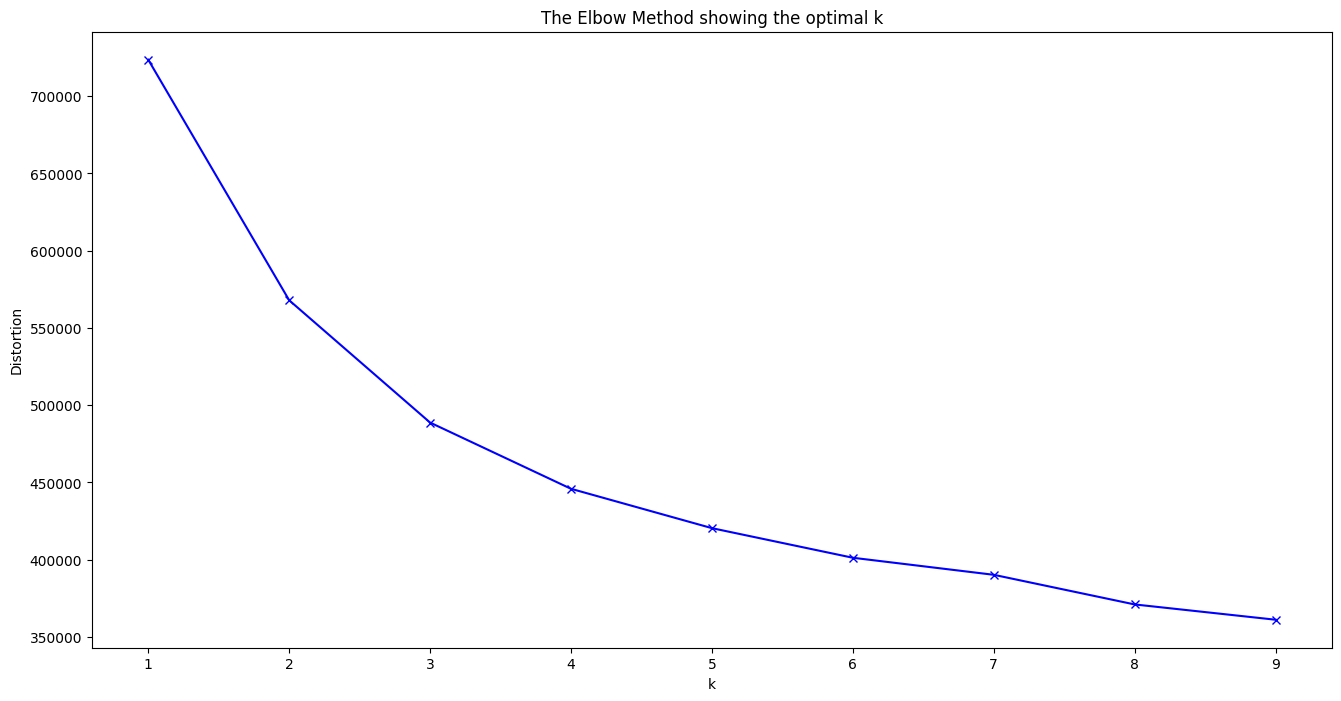

In [32]:
#Using the elbow method on Cosine distance
elbow_method(df_cosine, 10)

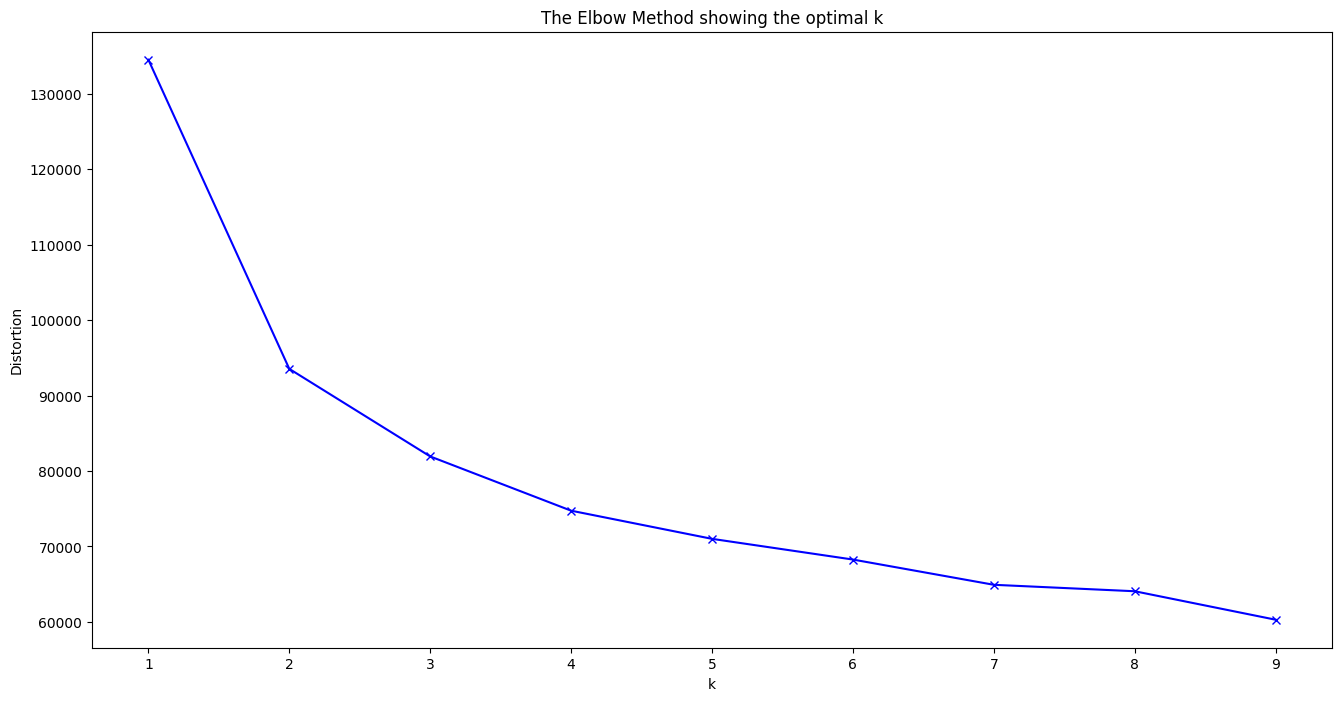

In [33]:
#Using the elbow method on Euclidean distance
elbow_method(Dist_euclidean, 10)

First, we have to modify our df in order to keep the first n users and assign our labels to them

In [34]:
# ratings_matrix = ratings_matrix.head(100)
ratings_matrix

Movie,0,1,2,3,4,5,6,7,8,9,...,29625,29626,29627,29628,29629,29630,29631,29632,29633,29634
User,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we'll use the PCA method in order to reduce the dimensionality of our matrix and plot our clusters

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# instantiate StandardScaler and PCA with 2 components for 2D scatter plot
scaler = StandardScaler()
pca = PCA(n_components=2)

# fit and transform the ratings matrix
ratings_pca = pca.fit_transform(ratings_matrix)

# print the explained variance ratio for each component
print(pca.explained_variance_ratio_)

[0.02618717 0.0154104 ]


In [36]:
# create a new dataframe with the PCA components and user index
df_pca = pd.DataFrame(ratings_pca, index=range(0, ratings_pca.shape[0]))
df_pca['Cluster'] = labels_euclidean
df_pca

,0,1,Cluster
0,5.154618,-3.067332,4
1,-9.511865,-1.496470,3
2,-3.294527,0.047731,3
3,37.042070,-15.166423,2
4,-13.542267,31.224639,0
...,...,...,...
523,24.172996,8.082540,4
524,-0.729154,-4.875287,4
525,-11.973097,-1.355159,1
526,-11.176632,-7.806115,1


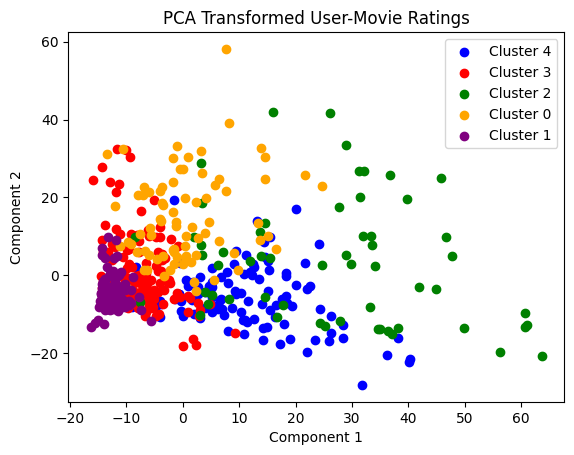

In [37]:
# create a scatter plot of the PCA components
fig, ax = plt.subplots()

for label, color in zip(df_pca['Cluster'].unique(), ['blue', 'red', 'green', 'orange', 'purple']):
    group = df_pca.groupby('Cluster').get_group(label)
    ax.scatter(group[0], group[1], c=color, label=f'Cluster {label}')

# set the axis labels and title
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title('PCA Transformed User-Movie Ratings')

# add a legend
ax.legend()

# show the plot
plt.show()

Movie  0      1      2      3      4      5      6      7      8      9      \
User                                                                          
0        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
523      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
524      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
525      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
526      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
527      0.0    0.0    0.0    0.0    0.0    0.0    0

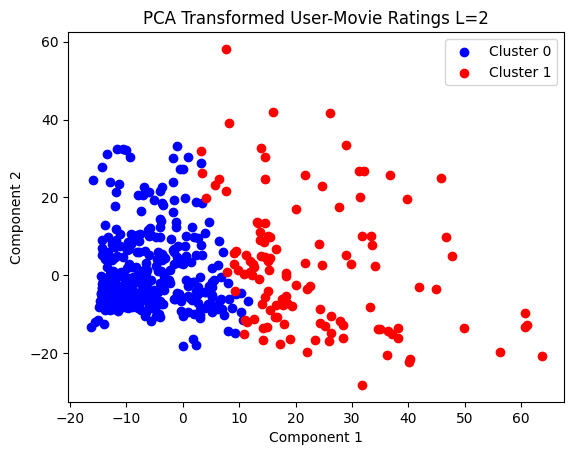

labels_euclidean [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1
 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1
 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1
 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 1 0 1 1
 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1
 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1
 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 1
 1 1 1 1

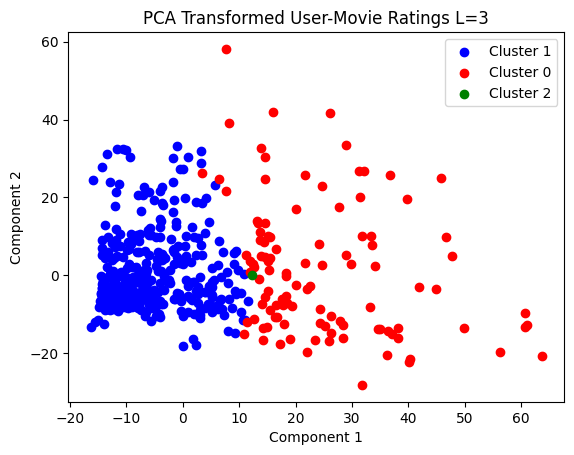

labels_euclidean [2 1 1 2 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 2 1 1 1 3 2 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 3 2 1 1 1 1 1 2 1 2 1 1 1 1 2 1 2 1 1 2
 1 2 1 1 1 1 1 1 2 1 1 2 2 1 1 3 1 2 1 1 1 2 1 2 1 1 1 1 2 1 1 2 1 3 1 1 1
 1 2 1 1 1 1 2 1 1 1 1 1 2 1 2 1 2 2 3 1 1 2 2 1 1 3 1 1 1 2 1 2 3 1 1 2 1
 2 1 1 2 1 2 1 2 2 2 3 1 2 1 1 1 1 1 2 1 2 2 1 2 3 1 1 1 1 2 1 2 1 2 1 1 1
 1 1 2 1 3 1 2 1 1 1 1 2 2 1 3 1 1 1 3 1 2 3 2 2 2 1 2 2 1 1 2 1 1 1 1 1 1
 2 1 1 1 2 1 2 1 1 2 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 2 1 3 2 1 3 2 1
 1 1 1 1 2 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 1 2 3 2 2 1 1 1 1 1 1 2 2 3 1
 1 1 2 1 1 1 2 1 1 2 3 1 1 1 1 1 2 1 1 1 2 2 1 1 1 2 2 1 1 2 1 1 2 1 2 1 1
 1 1 1 2 1 1 2 2 2 1 1 2 1 1 2 1 2 1 2 3 1 1 3 1 2 1 1 2 1 1 1 1 1 2 2 2 3
 1 1 2 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 1 3 1 1 2 2 2 2 3 2 2 1 1 1 1 1
 2 1 2 1 1 1 2 2 1 2 1 1 1 1 2 3 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 2 1 3 2 1 2
 3 1 2 1 1 1 1 3 1 1 1 2 1 2 1 1 2 2 1 1 1 1 2 2 2 1 1 1 2 1 2 1 1 3 2 2 1
 1 1 1 1

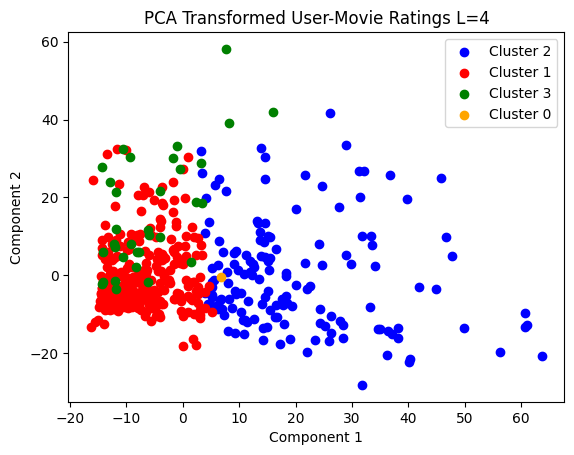

labels_euclidean [4 3 3 1 4 2 3 4 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 4 4 3 4 3 3 3 3 3 3 4 4 3
 3 4 3 4 3 4 3 3 3 3 4 3 3 3 4 3 3 3 1 3 4 3 3 3 1 4 1 4 3 3 3 4 3 1 4 3 1
 3 1 3 3 3 3 3 3 3 3 3 1 4 3 4 4 3 1 3 3 3 1 3 3 3 3 3 4 1 3 3 1 3 4 3 3 3
 3 4 3 4 3 3 4 3 3 3 3 0 3 3 1 4 3 4 4 4 3 1 1 3 3 3 4 3 3 3 4 1 4 3 3 3 3
 4 4 3 1 3 1 3 4 1 1 4 3 1 4 3 3 3 3 3 3 1 4 3 3 4 3 3 4 3 1 3 1 3 4 3 3 3
 3 4 1 3 4 3 4 3 4 3 4 1 4 3 4 4 3 3 3 3 1 4 1 1 4 3 4 3 3 3 4 4 3 3 4 4 3
 1 3 3 3 1 3 4 3 3 4 3 3 4 3 3 3 3 3 3 3 3 1 4 4 3 1 4 3 3 4 4 4 1 3 4 1 3
 3 3 3 3 3 3 3 3 3 4 1 3 1 3 4 3 3 3 4 3 1 4 3 4 4 4 1 3 4 3 3 3 3 1 1 3 3
 3 3 1 3 3 3 1 3 3 4 3 3 3 3 3 3 4 4 3 3 1 1 3 3 2 1 1 3 3 1 4 3 4 4 1 3 3
 3 3 3 1 3 3 1 1 1 3 3 1 3 3 3 3 1 3 1 4 3 4 3 3 1 3 3 1 3 3 3 3 3 4 1 4 3
 4 3 1 3 3 4 3 4 1 3 3 3 3 3 3 3 4 3 1 4 3 3 3 3 4 1 3 1 1 4 4 1 3 3 4 4 3
 1 4 1 3 4 3 1 4 3 1 3 3 4 4 1 4 3 4 1 1 3 3 3 3 3 1 3 3 4 3 3 4 3 4 3 4 4
 3 3 3 3 4 3 3 4 3 4 3 1 3 3 4 3 1 4 3 3 3 3 3 1 1 3 3 3 1 3 4 3 4 4 1 4 3
 3 4 4 3

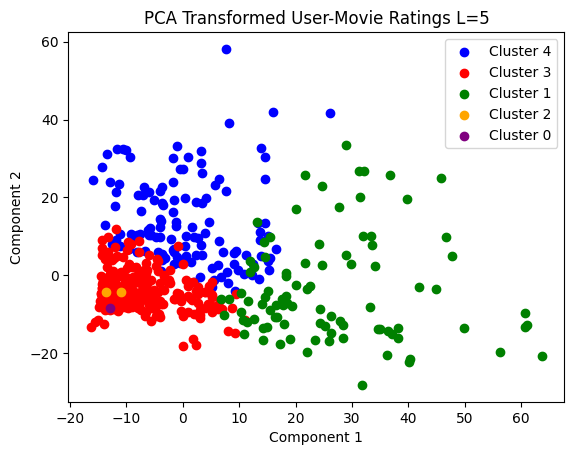

labels_euclidean [0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0
 1 0 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1
 1 0 1 0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0 0
 0 1 1 0 1 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0 1 1 1
 1 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0
 0 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1
 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 1 0 1 0 0 1 1
 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0
 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1
 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1
 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 0 0
 0 1 0 1 0 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0
 1 1 1 1

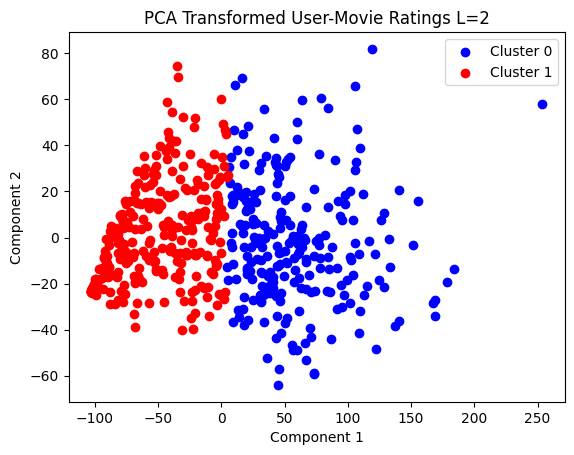

labels_euclidean [2 2 2 1 2 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 2 0 1 2 1 2 0 0 0 0 1 2 2 0
 0 0 0 2 0 2 0 0 2 2 0 0 0 0 1 0 0 0 1 2 2 0 0 0 2 2 2 2 2 0 0 2 0 1 2 0 1
 0 1 1 0 0 0 2 2 2 2 0 1 2 0 1 0 2 1 0 1 0 1 0 2 2 0 0 0 1 2 0 2 0 1 0 0 0
 0 1 0 2 0 2 2 2 2 0 0 0 1 0 1 0 1 2 2 2 2 1 1 0 0 0 2 0 0 2 0 1 2 0 1 2 2
 2 2 0 1 2 1 0 2 1 1 2 0 1 2 0 0 2 2 2 0 1 1 2 2 2 2 0 2 0 1 0 1 0 1 2 0 2
 0 0 1 0 1 0 1 2 2 0 1 1 1 2 2 0 0 0 0 0 2 0 1 2 2 2 2 2 0 2 2 1 0 0 2 2 2
 1 0 2 0 1 2 1 0 0 1 2 2 2 0 0 0 0 0 0 0 0 2 2 2 0 1 2 0 2 1 2 2 2 2 2 1 2
 0 2 0 0 2 0 2 0 0 0 1 1 1 0 2 0 2 0 2 0 1 2 0 2 2 1 1 0 2 0 0 1 0 2 2 2 0
 2 2 1 0 2 0 1 2 0 2 0 2 0 2 2 0 2 0 2 0 1 2 0 2 0 1 1 0 0 1 2 2 1 2 1 0 1
 2 0 0 1 0 0 1 1 1 0 0 1 0 0 1 2 1 0 1 2 1 0 0 0 1 2 2 1 2 0 2 0 0 2 1 2 2
 2 0 1 2 2 0 0 2 1 1 0 0 0 0 0 1 2 2 1 2 0 2 0 2 2 1 2 1 1 2 2 1 2 2 2 2 2
 1 1 2 0 1 1 2 2 0 2 2 2 0 1 1 2 0 2 2 2 2 0 1 0 0 1 2 2 2 0 2 1 0 0 1 1 2
 2 0 2 0 2 0 0 2 0 0 2 1 0 2 2 0 1 2 0 0 2 0 2 1 1 2 1 0 1 0 1 2 2 2 1 2 1
 0 2 2 2

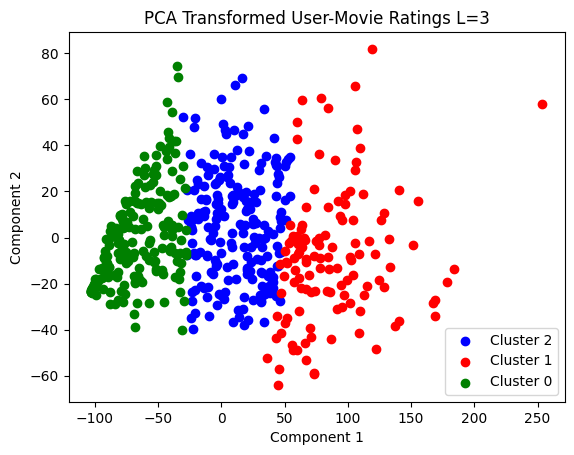

labels_euclidean [3 0 0 2 0 0 0 0 1 1 1 1 1 1 0 1 1 1 3 1 3 1 1 3 0 2 3 3 0 1 1 1 1 3 0 0 0
 1 0 1 0 0 0 1 1 0 0 0 1 1 1 2 1 1 1 3 0 0 0 1 1 3 0 3 0 0 1 1 0 0 2 0 1 3
 1 2 2 1 1 1 0 0 3 3 1 2 3 1 2 0 3 3 1 3 1 3 0 3 3 0 0 0 2 3 1 3 1 2 1 1 1
 1 2 1 0 0 0 3 0 0 0 0 1 3 1 2 0 2 3 3 3 0 2 2 1 1 0 0 0 1 3 0 2 0 1 3 3 3
 3 0 1 2 0 3 0 3 2 3 3 1 3 0 1 1 0 0 3 0 2 3 0 3 3 0 1 3 1 2 1 2 1 2 0 1 0
 1 0 2 1 2 1 2 3 0 1 3 3 3 0 0 0 1 1 0 1 3 0 2 3 3 0 3 3 0 0 3 3 1 1 3 0 3
 2 1 0 1 3 0 2 1 0 2 0 0 3 1 1 1 0 1 1 1 0 3 0 3 1 2 0 1 3 3 0 3 3 3 0 3 0
 0 0 1 1 3 1 0 1 1 0 2 3 2 0 3 0 0 0 3 1 2 0 1 3 3 3 3 1 0 1 1 3 1 3 3 0 1
 0 0 2 1 0 1 2 0 1 3 0 0 1 0 3 1 3 0 0 0 3 3 1 0 1 3 2 1 1 2 0 3 3 3 2 1 3
 0 1 0 3 1 0 3 3 2 1 0 3 0 1 3 0 3 0 2 0 3 1 0 1 3 0 0 2 0 1 3 0 0 3 3 3 0
 0 1 3 3 3 0 1 0 3 3 1 1 1 1 0 3 0 0 2 3 1 0 0 0 0 3 3 2 2 0 3 2 0 0 3 3 0
 2 3 3 1 2 2 3 3 0 3 3 0 0 3 2 0 1 3 3 3 0 1 2 1 0 3 0 0 3 1 0 3 1 0 2 2 3
 0 1 3 1 3 1 1 0 1 0 0 2 1 3 3 1 3 3 1 1 0 1 3 2 2 0 3 1 2 1 2 0 3 0 3 3 3
 0 0 0 0

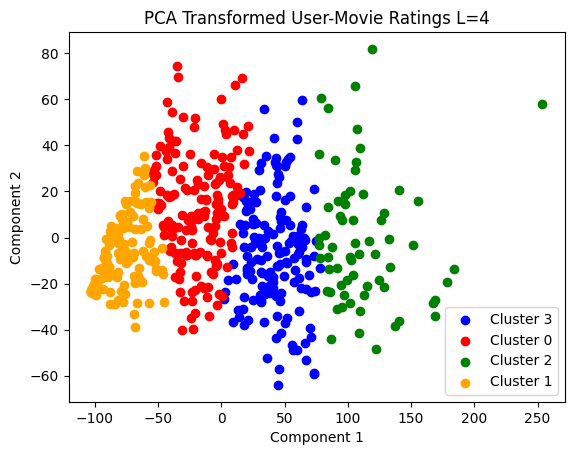

labels_euclidean [3 4 4 0 2 4 4 4 1 1 1 1 1 1 4 1 1 1 3 1 3 1 1 3 4 0 2 3 4 1 1 1 1 3 2 2 4
 1 4 1 2 4 2 1 1 4 4 4 1 1 1 2 1 1 1 3 4 2 4 1 1 3 2 3 4 4 1 1 4 4 0 2 4 3
 1 0 0 1 1 1 4 4 3 3 1 3 3 1 0 4 3 3 1 3 1 3 4 3 3 4 4 4 0 3 1 3 1 0 1 1 1
 1 0 1 2 4 4 2 4 4 4 4 1 3 1 0 4 0 3 2 2 4 0 0 1 1 4 4 4 1 3 4 0 4 1 3 3 3
 2 4 1 3 4 3 4 2 0 3 2 1 3 2 1 1 4 4 3 4 0 3 2 3 2 4 1 2 1 0 1 0 1 0 4 1 4
 1 4 0 1 2 1 0 3 4 1 3 3 3 4 2 4 1 1 4 1 3 4 0 3 2 4 2 3 4 4 2 2 1 1 2 2 3
 0 1 4 1 3 4 0 1 4 0 4 4 2 1 1 4 4 1 1 1 4 3 4 2 1 0 2 1 3 3 2 2 3 2 4 3 4
 4 4 1 1 3 1 4 1 1 4 0 3 3 4 2 4 4 4 3 1 0 4 1 2 2 3 3 1 4 4 1 3 1 3 3 4 1
 4 4 0 1 4 1 3 4 4 2 4 4 1 4 3 1 3 4 4 4 3 3 1 4 1 3 0 1 1 0 4 3 3 2 0 1 3
 2 1 4 3 1 4 3 3 0 1 4 3 4 1 3 4 3 4 0 2 3 1 4 1 3 4 4 0 4 1 3 4 4 2 3 2 4
 2 1 3 3 3 4 1 2 3 3 1 1 1 1 4 3 4 4 0 2 1 4 4 4 2 3 3 0 0 4 2 0 4 4 2 3 4
 0 2 3 1 0 0 3 2 4 3 2 4 4 2 0 4 1 2 2 3 2 1 0 1 4 3 4 4 2 1 2 3 1 4 0 0 2
 2 1 3 1 2 1 1 2 1 4 4 0 1 3 2 1 3 3 1 1 4 1 3 3 0 4 3 1 0 1 0 4 2 2 3 2 3
 4 4 4 4

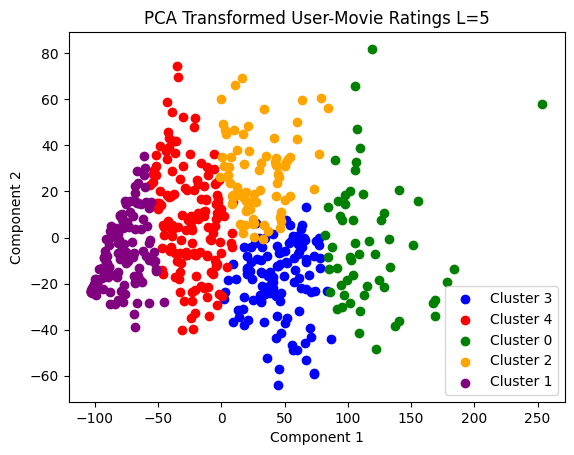

In [63]:
# THANOS INVESTIGATION
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
# import pyclustering
# from pyclustering import cluster
# from pyclustering.cluster import kmeans


def thanos_elbow_method(df: pd.DataFrame, max_iter: int):
    distortions = []
    K = range(1, max_iter)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, n_init=10)
        kmeanModel.fit(df)
        distortions.append(kmeanModel.inertia_)
    plt.figure(figsize=(16, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()


def plot_pca(df_pca: pd.DataFrame, title: str):
    # create a scatter plot of the PCA components
    fig, ax = plt.subplots()
    for label, color in zip(df_pca['Cluster'].unique(), ['blue', 'red', 'green', 'orange', 'purple']):
        group = df_pca.groupby('Cluster').get_group(label)
        ax.scatter(group[0], group[1], c=color, label=f'Cluster {label}')

    # set the axis labels and title
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_title(title)
    # add a legend
    ax.legend()
    # show the plot
    plt.show()


def do_kmeans_and_plot_pca_euclidean(df: pd.DataFrame, L: int, ) -> tuple[KMeans, pd.DataFrame]:
    kmeans = KMeans(n_clusters=L, n_init=10).fit(df)

    kmeans_labels = kmeans.labels_
    # Print the labels
    print('labels_euclidean', kmeans_labels)

    X_new = kmeans.transform(df)

    # instantiate StandardScaler and PCA with 2 components for 2D scatter plot
    scaler = StandardScaler()
    pca = PCA(2)
    ratings_pca = pca.fit_transform(df)

    # create a new dataframe with the PCA components and user index
    print('df.shape[0]', df.shape[0])
    df_pca = pd.DataFrame(ratings_pca, index=range(0, df.shape[0]))
    df_pca['Cluster'] = kmeans_labels
    plot_pca(df_pca,  f"PCA Transformed User-Movie Ratings L={L}")
    return (kmeans, df_pca)


def create_and_plot_pca_df_pyclustering(df: pd.DataFrame, L: int, title: str) -> tuple[kmeans, pd.DataFrame]:
    initial_centers = kmeans_plusplus_initializer(df, L).initialize()
    kmeans_instance = kmeans(df, initial_centers)
    kmeans_instance.process()
    # Get the cluster labels
    labels_euclidean = kmeans_instance.get_cluster_encoding()

    # Print the labels
    print('labels_euclidean', labels_euclidean)

    # instantiate StandardScaler and PCA with 2 components for 2D scatter plot
    scaler = StandardScaler()
    pca = PCA(2)
    ratings_pca = pca.fit_transform(df)

    # create a new dataframe with the PCA components and user index
    print('df.shape[0]', df.shape[0])
    df_pca = pd.DataFrame(ratings_pca, index=range(0, df.shape[0]))
    df_pca['Cluster'] = labels_euclidean
    plot_pca(df_pca, title)
    return (kmeans_instance, df_pca)


print(ratings_matrix)

for L in range(2, 6):
    do_kmeans_and_plot_pca_euclidean(ratings_matrix, L)

for L in range(2, 6):
    D_df = df_euclidean = pd.DataFrame(D)
    do_kmeans_and_plot_pca_euclidean(D_df, L)

# do_kmeans_euclidean_I(5)
# do_kmeans_euclidean_I(2)
# do_kmeans_euclidean_I(3)
# do_kmeans_euclidean_I(4)
# do_kmeans_euclidean_I(5)
# do_kmeans_euclidean_U(2)
# do_kmeans_euclidean_U(3)
# do_kmeans_euclidean_U(4)
# do_kmeans_euclidean_U(5)
# def do_kmeans_euclidean(L: int):
#     D_df = df_euclidean = pd.DataFrame(D)
#     thanos_df_pca = create_and_plot_pca_df(ratings_matrix, D_df)
#     plot_pca(thanos_df_pca)
#     print()
